SAHI is a technique for improving the detection rate for smaller objects with object detection models. SAHI works by running inference on “slices’ of an image, then combining the results across the whole image. supervision has a built-in SAHI feature you can use to run SAHI on any model for which there is a data loader in supervision.

## USING SUPERVISION

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [12]:
!pip install ultralytics supervision sahi opencv-python wandb -q

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.186 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.8/78.2 GB disk)


In [28]:
import supervision as sv
import numpy as np
from numpy import asarray
import cv2
# Import YOLOv8-S model
from sahi.utils.yolov8 import (
    download_yolov8s_model,
)
from sahi import AutoDetectionModel
from sahi.predict import get_prediction, get_sliced_prediction, predict
from sahi.prediction import visualize_object_predictions
from sahi.utils.file import download_from_url

from IPython.display import Image
from ultralytics import YOLO

model = YOLO("yolov8x.pt")

def callback(x: np.ndarray) -> sv.Detections:
    result = model(x, verbose=False, conf=0.25)[0]
    return sv.Detections.from_ultralytics(result)

In [18]:
# Download test images into demo_data folder
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/small-vehicles1.jpeg', 'demo_data/small-vehicles1.jpeg')
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/terrain2.png', 'demo_data/terrain2.png')

## Run Inference with the SAHI Slicer

In [30]:
image = cv2.imread("/content/demo_data/bridge.png")

slicer = sv.InferenceSlicer(callback=callback)
sliced_detections = slicer(image=image)

To display SAHI predictions, we can use the following code:

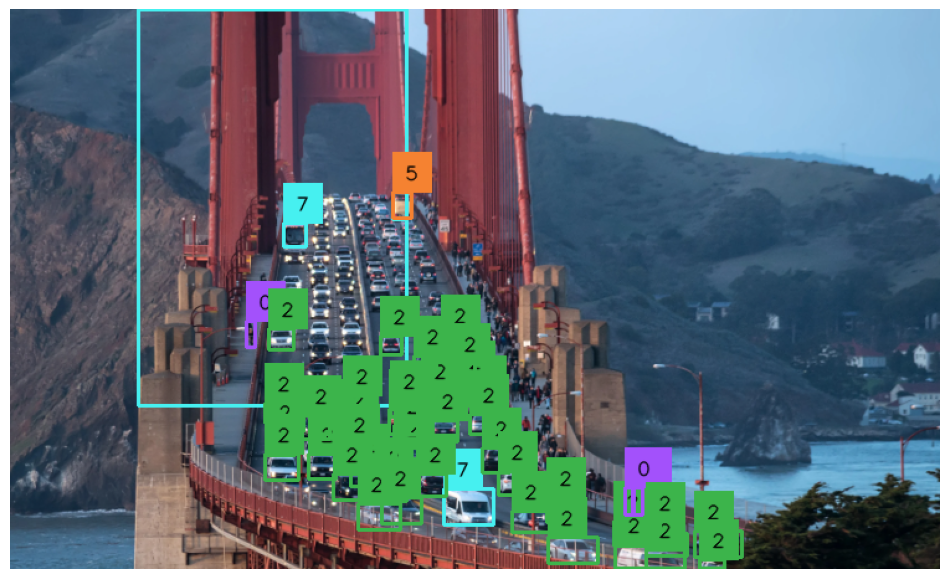

In [31]:
box_annotator = sv.BoxAnnotator()

sliced_image = box_annotator.annotate(image.copy(), detections=sliced_detections)

sv.plot_image(sliced_image)

In [22]:
# Download YOLOv8-S model to 'models/yolov8s.pt'
yolov8_model_path = 'models/yolov8s.pt'
download_yolov8s_model(destination_path=yolov8_model_path)

In [23]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=yolov8_model_path,
    confidence_threshold=0.3,
    device="cuda:0", # or 'cpu'
)

## Perform Inference and Visualize (without SAHI)

In [25]:
result = get_prediction("demo_data/bridge.png", detection_model)

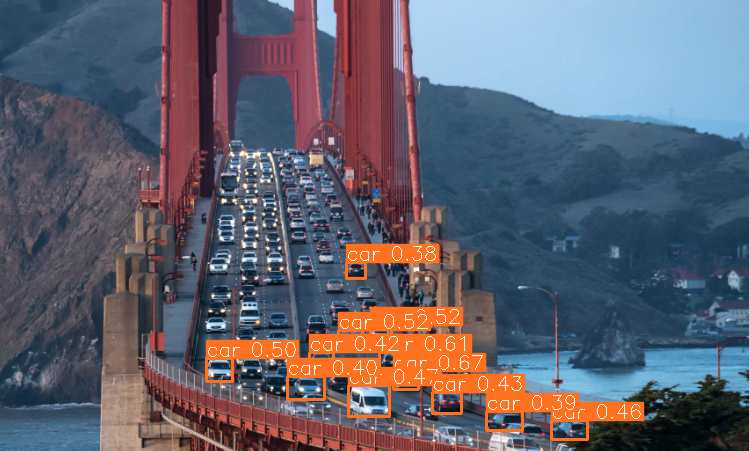

In [26]:
result.export_visuals(export_dir="demo_data/")

Image("demo_data/prediction_visual.png")

## Perform Sliced Inference (with SAHI)
NOTE: To perform sliced prediction we need to specify slice parameters. In this example we will perform prediction over slices of 512x512 with an overlap ratio of 0.2:

In [27]:
# Example 1
result = get_sliced_prediction(
    "demo_data/bridge.png",
    detection_model,
    slice_height = 128,
    slice_width = 128,
    overlap_height_ratio = 0.7,
    overlap_width_ratio = 0.7
)

Performing prediction on 170 number of slices.


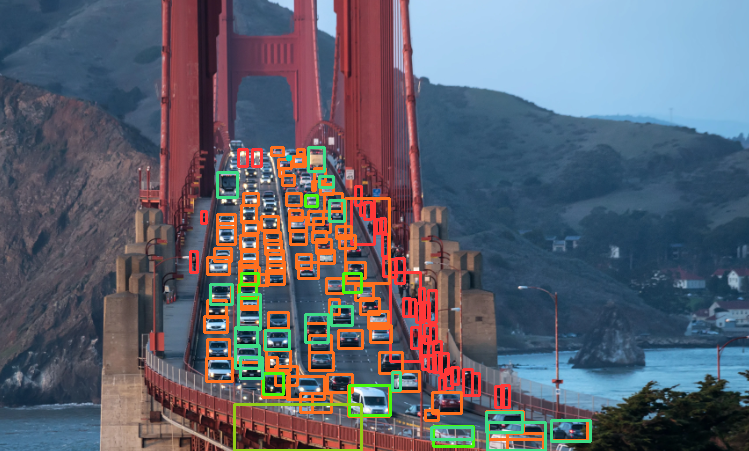

In [29]:
img = cv2.imread("demo_data/bridge.png", cv2.IMREAD_UNCHANGED)
img_converted = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
numpydata = asarray(img_converted)
visualize_object_predictions(
    numpydata,
    object_prediction_list = result.object_prediction_list,
    hide_labels = 1,
    output_dir='/content/demo_data',
    file_name = 'result',
    export_format = 'png'
)
Image('demo_data/result.png')

In [32]:
# Example 2
result = get_sliced_prediction(
    "demo_data/bird.jpg",
    detection_model,
    slice_height = 256,
    slice_width = 256,
    overlap_height_ratio = 0.2,
    overlap_width_ratio = 0.2
)

Performing prediction on 60 number of slices.


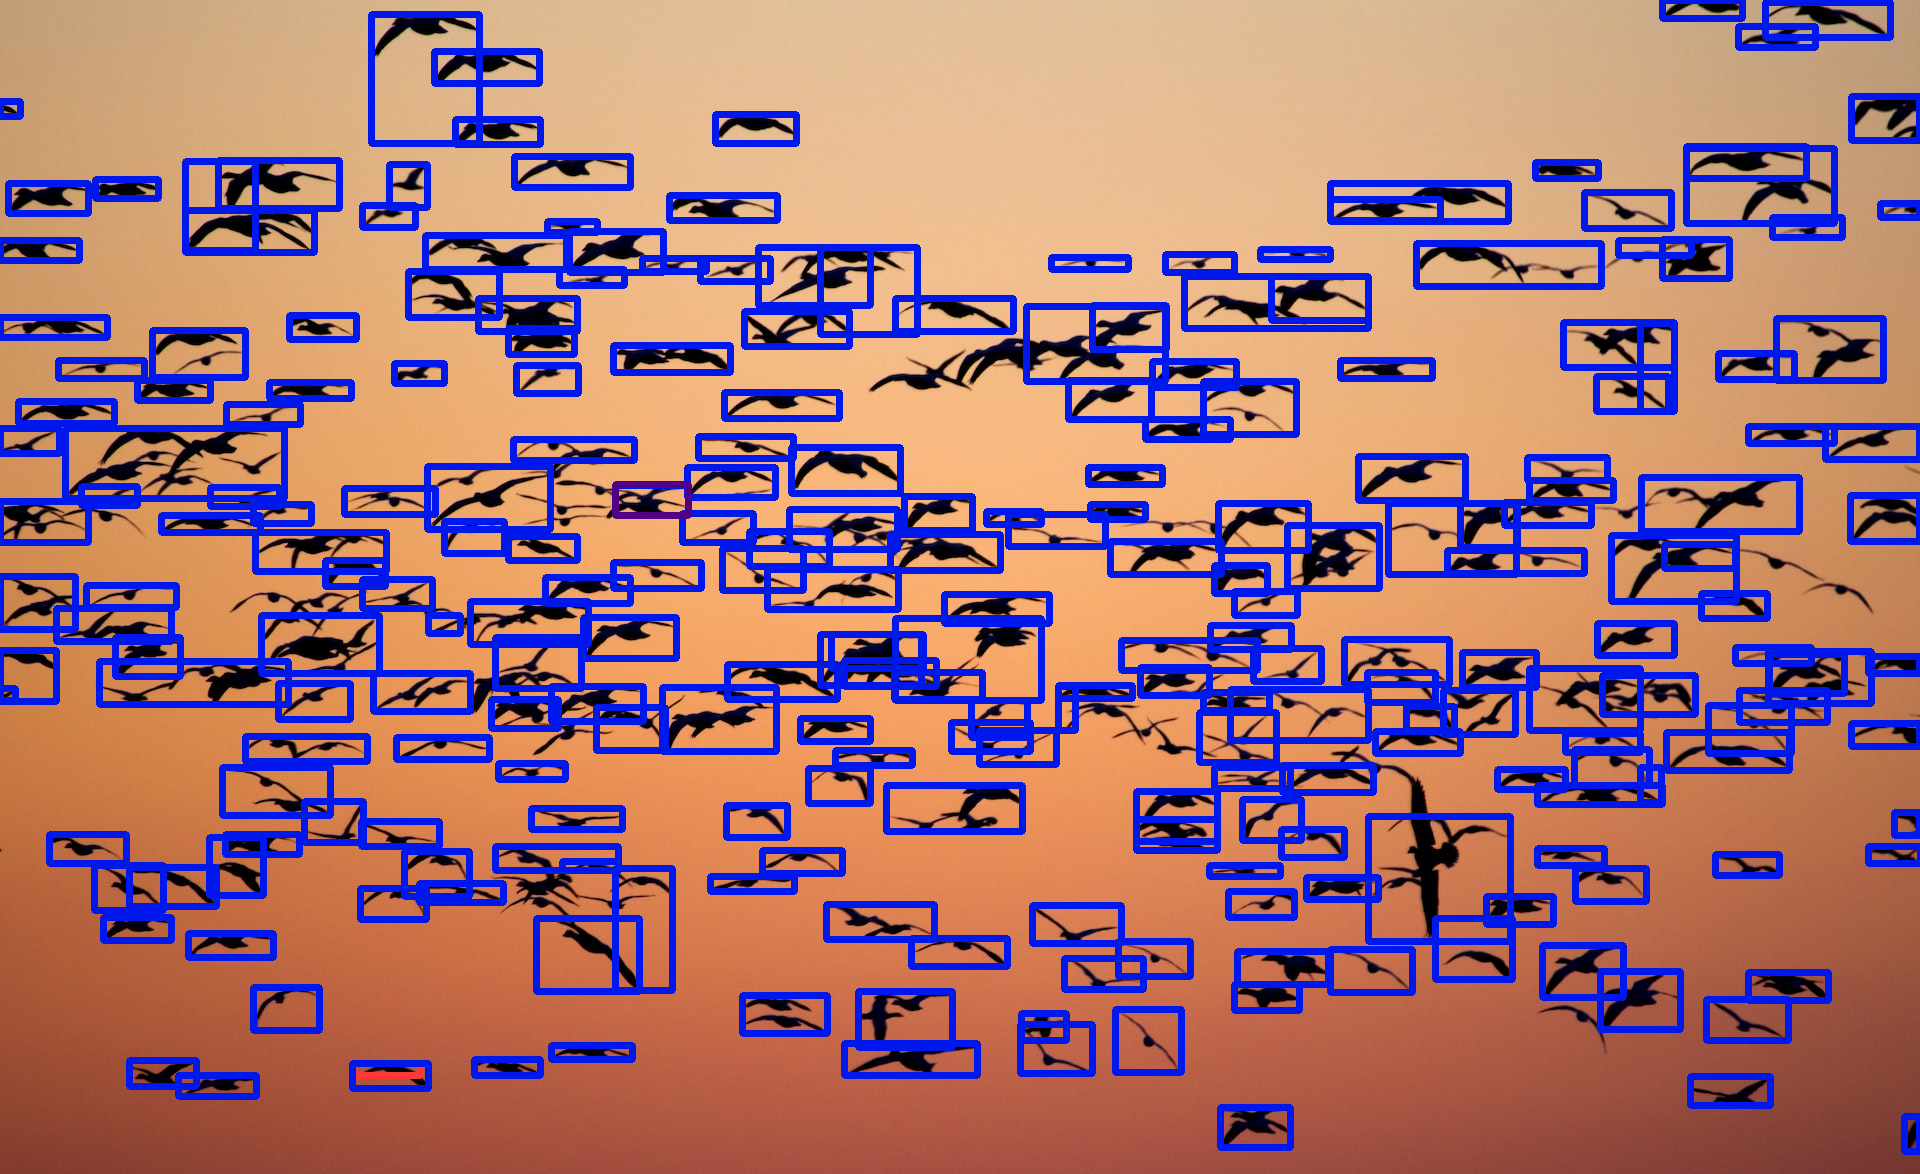

In [33]:
img = cv2.imread("demo_data/bird.jpg", cv2.IMREAD_UNCHANGED)
img_converted = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
numpydata = asarray(img_converted)
visualize_object_predictions(
    numpydata,
    object_prediction_list = result.object_prediction_list,
    hide_labels = 1,
    output_dir='/content/demo_data',
    file_name = 'result',
    export_format = 'png'
)
Image('demo_data/result.png')